In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Attention Optimizer

In [ ]:
def attention_optimizer(candidates_x, func, learning_rate, iterations):
    history = []
    current_candidates = np.array(candidates_x, dtype=float)
    min_loss_so_far = float('inf')

    start_time = time.time()
    for t in range(iterations):
        losses = func(current_candidates)
        min_loss_so_far = min(min_loss_so_far, np.min(losses).item())

        # calculating attention weights
        exp_losses = np.exp(-(losses - np.max(losses)))
        attention_weights = exp_losses / np.sum(exp_losses)

        # calculating weighted average point
        x_weighted_average = np.sum(attention_weights[:, np.newaxis] * current_candidates, axis=0)

        current_candidates = current_candidates + learning_rate * (x_weighted_average - current_candidates)

        history.append(min_loss_so_far)

    end_time = time.time()
    return np.array(history), end_time - start_time

## Gradient Descent

In [ ]:
def gradient_descent(start_x, func, grad_func, learning_rate, iterations):
    history = []
    current_x = np.array(start_x, dtype=float)

    start_time = time.time()
    for t in range(iterations):
        grad = grad_func(current_x)
        current_x = current_x - learning_rate * grad

        if np.any(np.isnan(current_x)) or np.any(np.isinf(current_x)):
             history.append(float('nan'))
             break
        history.append(func(current_x).item())

    end_time = time.time()
    return np.array(history), end_time - start_time

In [ ]:
# SPHERE FUNCTION
def sphere(x):
    return np.sum(x**2, axis=-1)

def grad_sphere(x):
    return 2 * x

# RASTRIGIN FUNCTION
def rastrigin(x):
    D = x.shape[-1]
    A = 10.0

    return (A * D + np.sum(x**2 - A * np.cos(2 * np.pi * x), axis=-1))

def grad_rastrigin(x):
    return (2 * x + 20 * np.pi * np.sin(2 * np.pi * x));

# ACKLEY FUNCTION
def ackley(x):
    D = x.shape[-1]

    sum_sq = np.sum(x**2, axis=-1)
    sum_cos = np.sum(np.cos(2 * np.pi * x), axis=-1)

    return ((-20.0 * np.exp(-0.2 * np.sqrt(sum_sq / D))) + (-np.exp(sum_cos / D)) + 20.0 + np.e);

def grad_ackley(x):
    D = x.shape[-1]

    r_sq = np.sum(x**2, axis=-1, keepdims=True)
    r = np.sqrt(r_sq)
    r_safe = np.where(r == 0, 1e-10, r)

    exp1 = np.exp(-0.2 * r / np.sqrt(D))
    grad_part1_coeff = (4.0 / (r_safe * np.sqrt(D))) * exp1
    grad_part1 = grad_part1_coeff * x

    sum_cos = np.sum(np.cos(2 * np.pi * x), axis=-1, keepdims=True)
    exp2 = np.exp(sum_cos / D)

    grad_part2_coeff = (2.0 * np.pi / D) * exp2
    grad_part2 = grad_part2_coeff * np.sin(2 * np.pi * x)

    grad = grad_part1 + grad_part2

    grad[r_sq.squeeze() == 0] = 0.0

    return grad

# GRIEWANK FUNCTION
def griewank(x):
    D = x.shape[-1]
    indices = np.arange(1, D + 1)

    return ((np.sum(x**2, axis=-1) / 4000.0) - (np.prod(np.cos(x / np.sqrt(indices)), axis=-1)) + 1.0);

def grad_griewank(x):
    D = x.shape[-1]
    indices = np.arange(1, D + 1)
    sqrt_indices = np.sqrt(indices)

    grad_part1 = x / 2000.0

    cos_k = np.cos(x / sqrt_indices)
    sin_k = np.sin(x / sqrt_indices)

    log_cos_terms = np.log(np.abs(cos_k))
    log_P = np.sum(log_cos_terms, axis=-1, keepdims=True)
    log_P_without_k = log_P - log_cos_terms

    P = np.prod(cos_k, axis=-1, keepdims=True)
    signs = np.sign(P) * np.sign(cos_k)

    P_without_k = signs * np.exp(log_P_without_k)

    grad_part2 = P_without_k * sin_k / sqrt_indices

    return grad_part1 + grad_part2

In [ ]:
def generate_initial_candidates(D, N=10, bounds=5.0):
    np.random.seed(42 + D)
    candidates = np.random.uniform(low=-bounds, high=bounds, size=(N, D))
    start_point_gd = candidates[0].copy()
    return candidates, start_point_gd

In [ ]:
def run_test_case(func, grad_func, func_name, initial_candidates, start_point_gd, lr_attn, lr_gd, max_iter, D):
    N_candidates = len(initial_candidates)

    print(f"\nTesting {func_name} (Dimension={D})")

    # ATTENTION OPTIMIZER
    attn_history, attn_duration = attention_optimizer(
        candidates_x=initial_candidates,
        func=func,
        learning_rate=lr_attn,
        iterations=max_iter
    )

    # GRADIENT DESCENT
    gd_history, gd_duration = gradient_descent(
        start_x=start_point_gd,
        func=func,
        grad_func=grad_func,
        learning_rate=lr_gd,
        iterations=max_iter
    )

    gd_final_loss = gd_history[-1] if gd_history.size > 0 and not np.isnan(gd_history[-1]) else float('nan')

    df = pd.DataFrame({
        "Metric": ["Final Loss", "Computation Time (s)"],
        "Attention Optimizer": [
            f"{attn_history[-1]:.2e}" if not np.isnan(attn_history[-1]) else "nan",
            f"{attn_duration:.4f}"
        ],
        "Gradient Descent": [
            f"{gd_final_loss:.2e}" if not np.isnan(gd_final_loss) else "nan",
            f"{gd_duration:.4f}"
        ]
    })

    print(df.to_markdown(index=False))

    plt.figure(figsize=(10, 6))
    plt.plot(attn_history, label='Attention Optimizer', color='#3b82f6')
    plt.plot(gd_history, label='Gradient Descent', color='#ef4444')

    plot_title = f'Loss for {func_name}'
    plt.title(plot_title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')

    if func_name in ["Rastrigin Function", "Ackley Function", "Griewank Function"]:
        plt.yscale('log')
    else:
        plt.yscale('linear')

    plt.legend()
    plt.show()

In [ ]:
def run_per_dimension(D):
    max_iterations = 200
    bounds = 5.0
    n_candidates = 10
    initial_candidates, start_point_gd = generate_initial_candidates(D, N=n_candidates, bounds=bounds)

    # 1. SPHERE FUNCTION
    run_test_case(
        func=sphere,
        grad_func=grad_sphere,
        func_name="Sphere Function",
        initial_candidates=initial_candidates,
        start_point_gd=start_point_gd,
        lr_attn=0.1,
        lr_gd=0.05,
        max_iter=max_iterations,
        D=D
    )

    # RASTRIGIN FUNCTION
    run_test_case(
        func=rastrigin,
        grad_func=grad_rastrigin,
        func_name="Rastrigin Function",
        initial_candidates=initial_candidates,
        start_point_gd=start_point_gd,
        lr_attn=0.01,
        lr_gd=0.005,
        max_iter=max_iterations,
        D=D
    )

    # ACKLEY FUNCTION
    run_test_case(
        func=ackley,
        grad_func=grad_ackley,
        func_name="Ackley Function",
        initial_candidates=initial_candidates,
        start_point_gd=start_point_gd,
        lr_attn=0.01,
        lr_gd=0.005,
        max_iter=max_iterations,
        D=D
    )

    # GRIEWANK FUNCTION
    run_test_case(
        func=griewank,
        grad_func=grad_griewank,
        func_name="Griewank Function",
        initial_candidates=initial_candidates,
        start_point_gd=start_point_gd,
        lr_attn=0.01,
        lr_gd=0.005,
        max_iter=max_iterations,
        D=D
    )

## Dimension: 2


Testing Sphere Function (Dimension=2)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |               0.00115 |           1.34e-17 |
| Computation Time (s) |               0.0126  |           0.0071   |


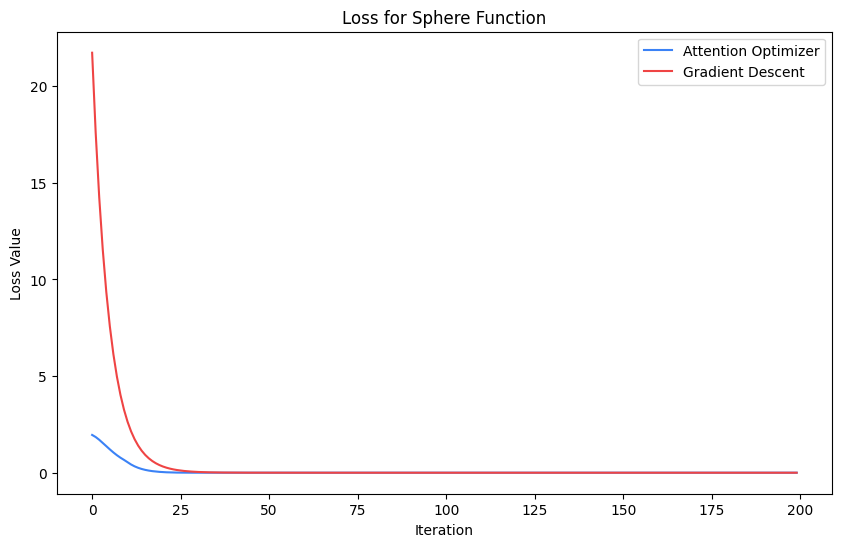


Testing Rastrigin Function (Dimension=2)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                 1.28  |            24.9    |
| Computation Time (s) |                 0.011 |             0.0092 |


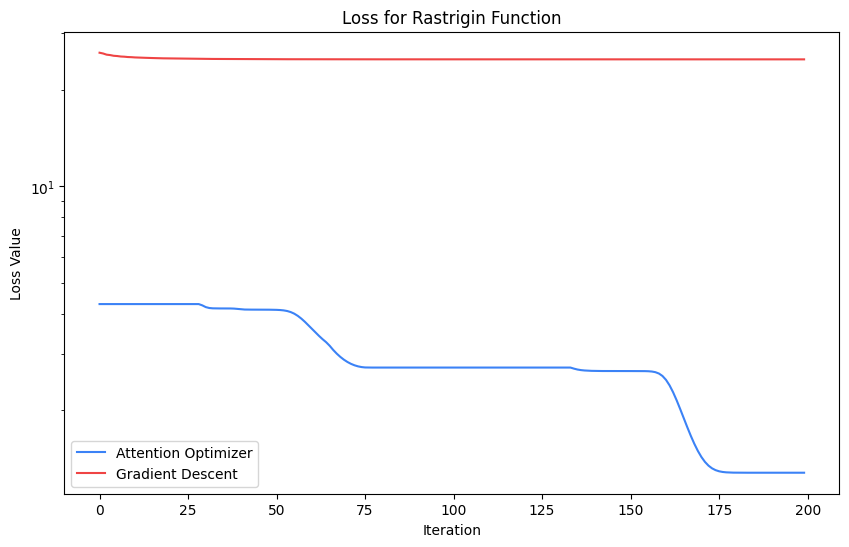


Testing Ackley Function (Dimension=2)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                1.44   |             10.1   |
| Computation Time (s) |                0.0476 |              0.069 |


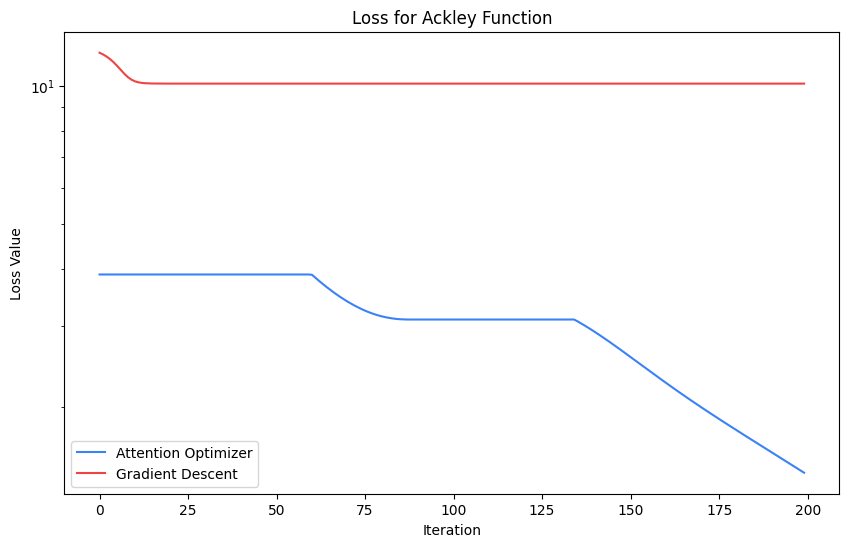


Testing Griewank Function (Dimension=2)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                0.0165 |             0.0326 |
| Computation Time (s) |                0.0549 |             0.0626 |


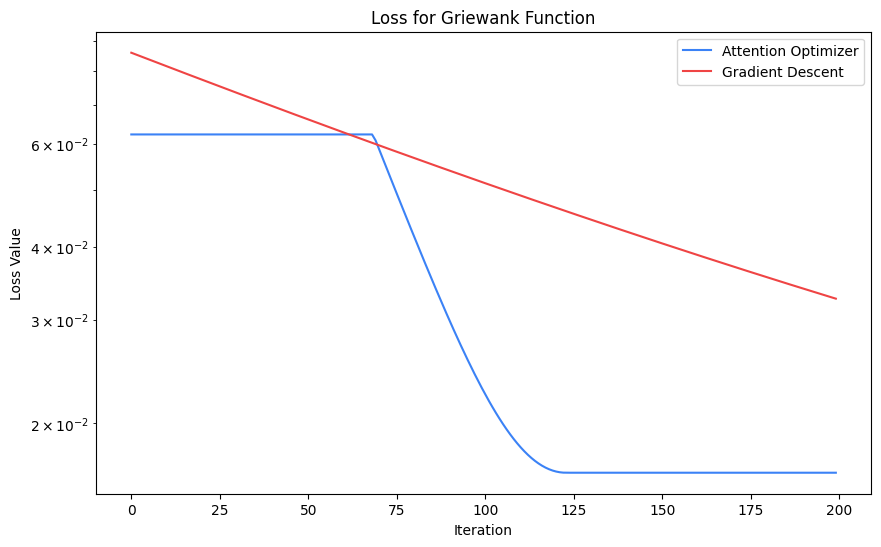

In [ ]:
run_per_dimension(2);

## Dimension: 5


Testing Sphere Function (Dimension=5)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                0.496  |           2.45e-17 |
| Computation Time (s) |                0.0514 |           0.0153   |


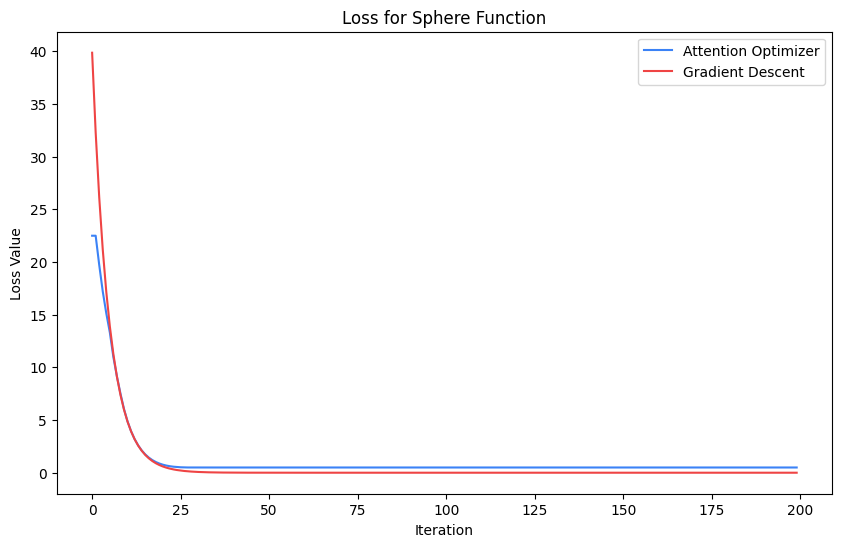


Testing Rastrigin Function (Dimension=5)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |               22.7    |            49.7    |
| Computation Time (s) |                0.0596 |             0.0309 |


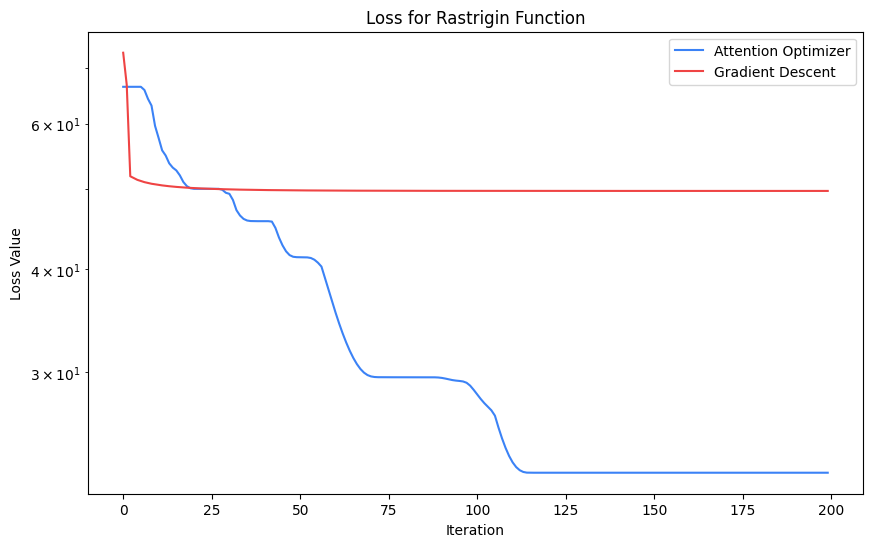


Testing Ackley Function (Dimension=5)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                2.88   |             9.35   |
| Computation Time (s) |                0.0438 |             0.0276 |


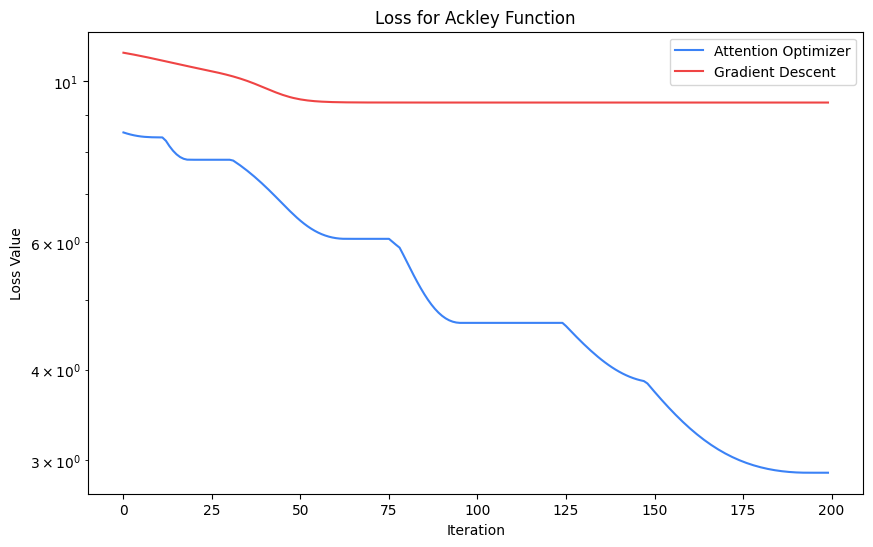


Testing Griewank Function (Dimension=5)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                0.211  |             0.882  |
| Computation Time (s) |                0.0454 |             0.0623 |


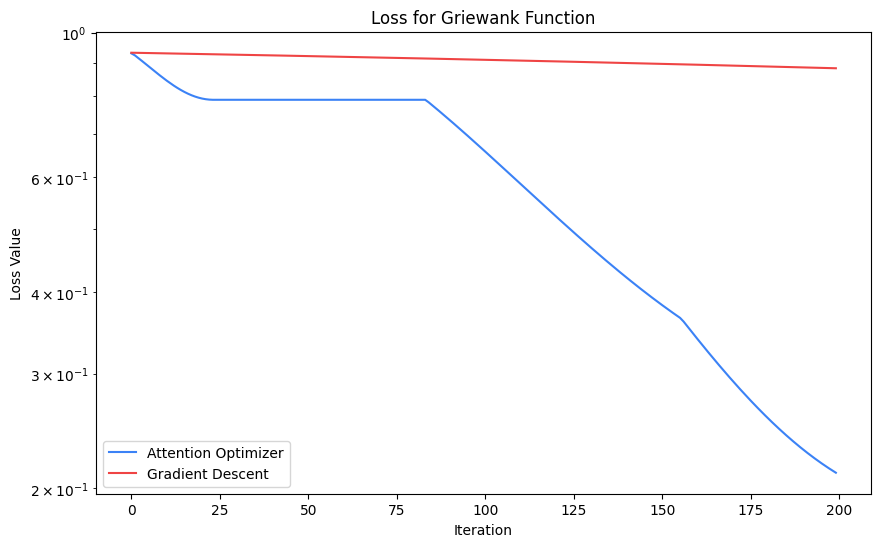

In [ ]:
run_per_dimension(5);

## Dimension: 10


Testing Sphere Function (Dimension=10)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                3.94   |            6.2e-17 |
| Computation Time (s) |                0.0176 |            0.0065  |


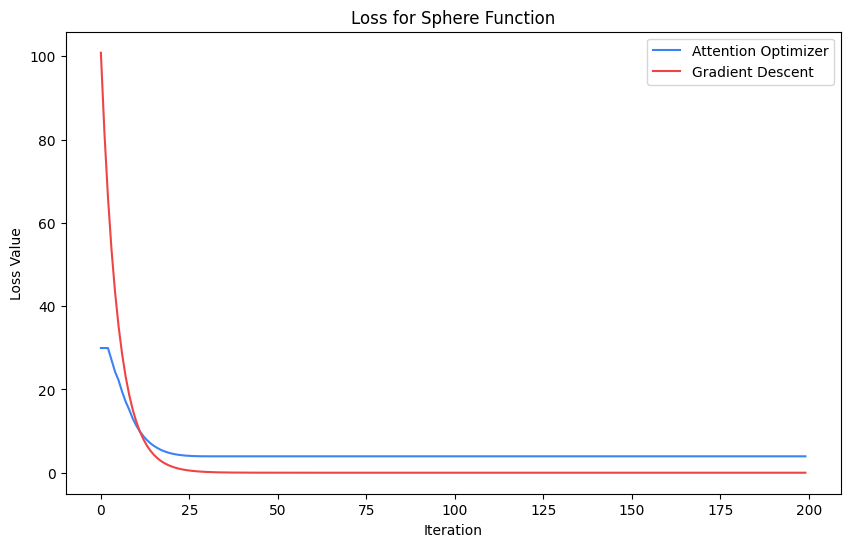


Testing Rastrigin Function (Dimension=10)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |               64.4    |           126      |
| Computation Time (s) |                0.0246 |             0.0102 |


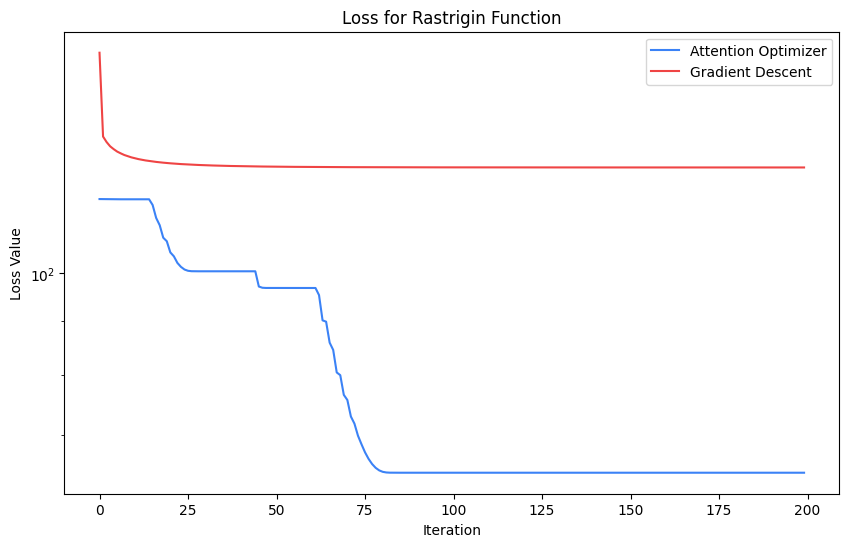


Testing Ackley Function (Dimension=10)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                4.2    |            10.2    |
| Computation Time (s) |                0.0287 |             0.0624 |


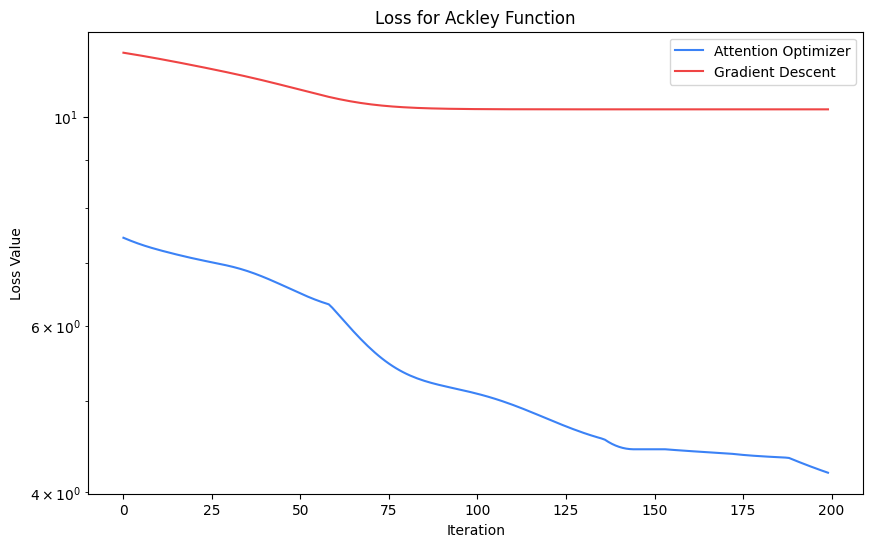


Testing Griewank Function (Dimension=10)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                0.465  |             1.03   |
| Computation Time (s) |                0.0695 |             0.0446 |


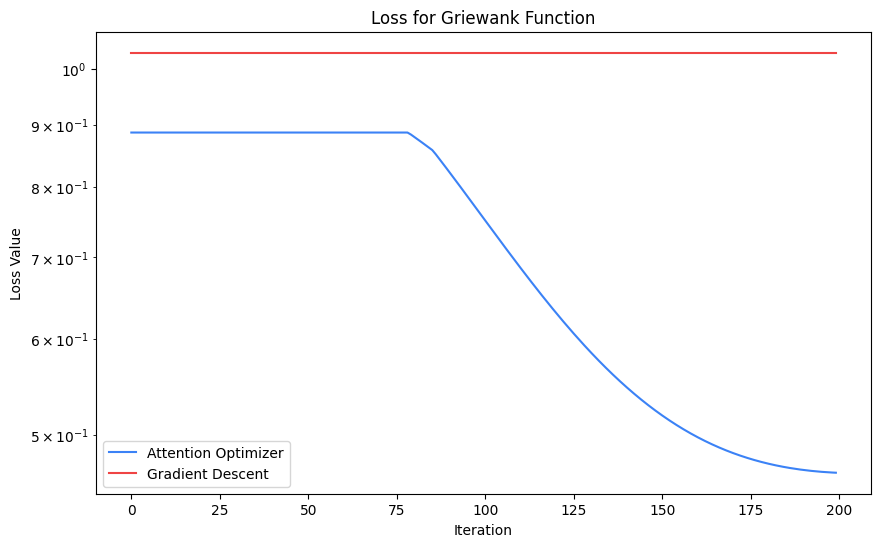

In [ ]:
run_per_dimension(10);

## Dimension: 50


Testing Sphere Function (Dimension=50)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                33.6   |           1.91e-16 |
| Computation Time (s) |                 0.014 |           0.0063   |


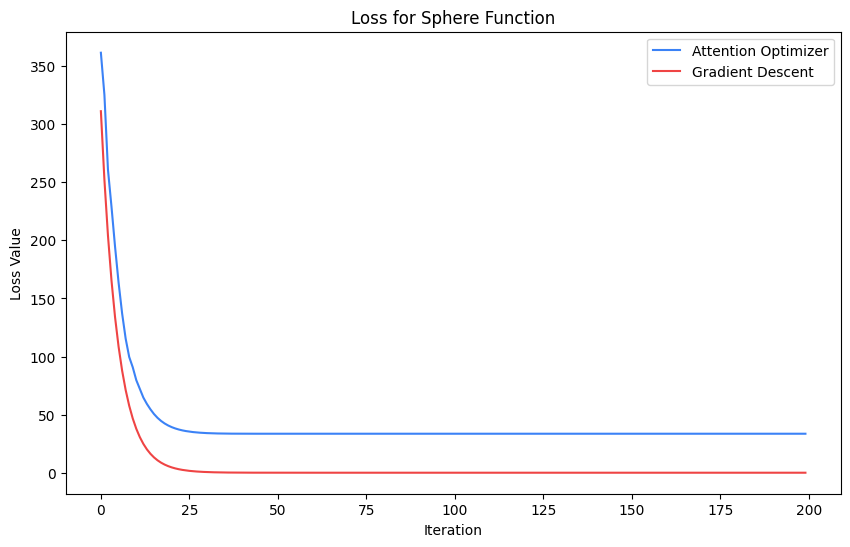


Testing Rastrigin Function (Dimension=50)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |              473      |           378      |
| Computation Time (s) |                0.0213 |             0.0117 |


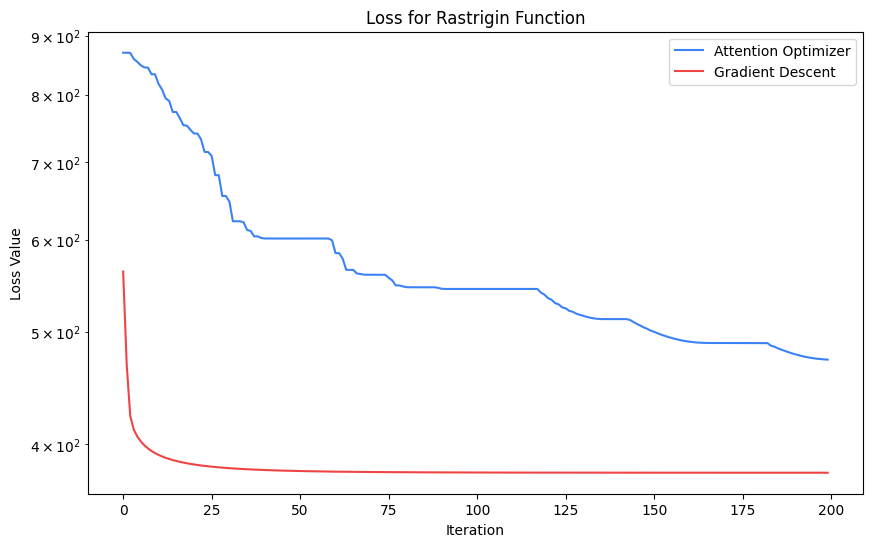


Testing Ackley Function (Dimension=50)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                4.89   |             9.38   |
| Computation Time (s) |                0.0283 |             0.0268 |


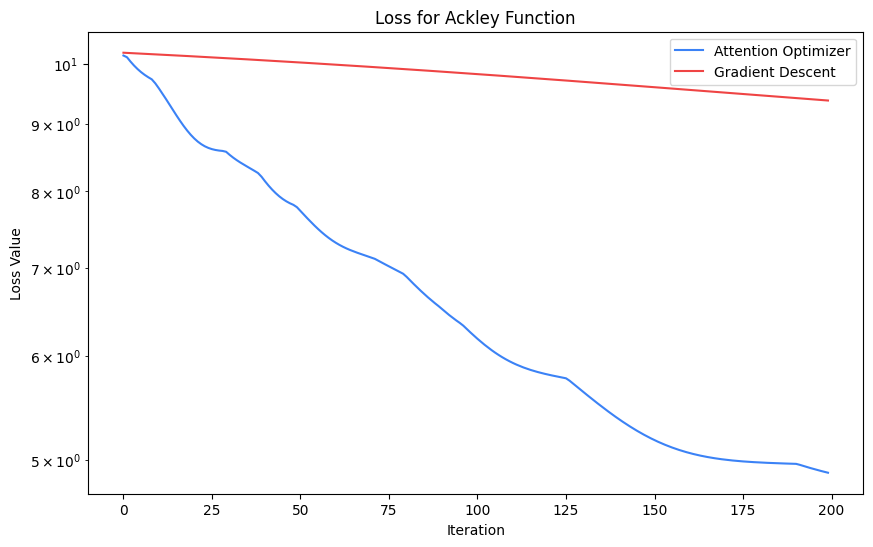


Testing Griewank Function (Dimension=50)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                 0.827 |             1.1    |
| Computation Time (s) |                 0.022 |             0.0245 |


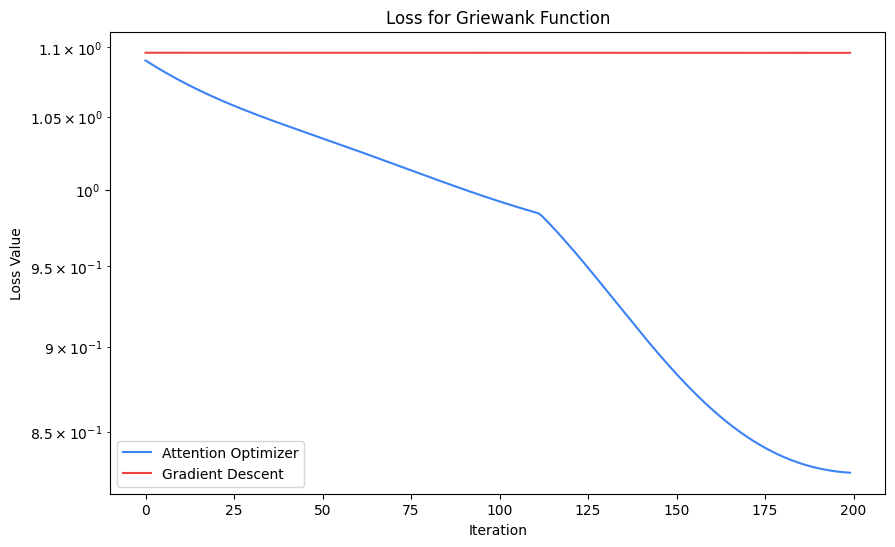

In [ ]:
run_per_dimension(50);

## Dimension: 100


Testing Sphere Function (Dimension=100)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |               81      |           4.22e-16 |
| Computation Time (s) |                0.0152 |           0.0046   |


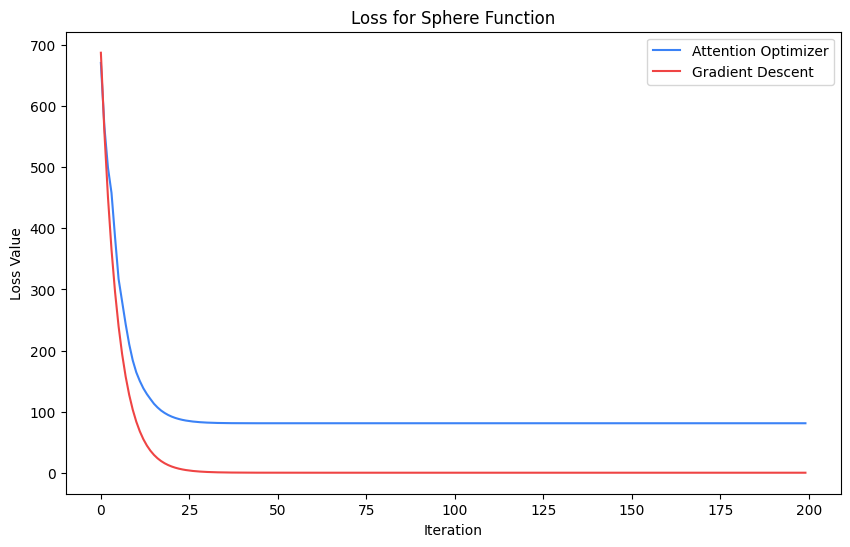


Testing Rastrigin Function (Dimension=100)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |             1010      |           868      |
| Computation Time (s) |                0.0224 |             0.0066 |


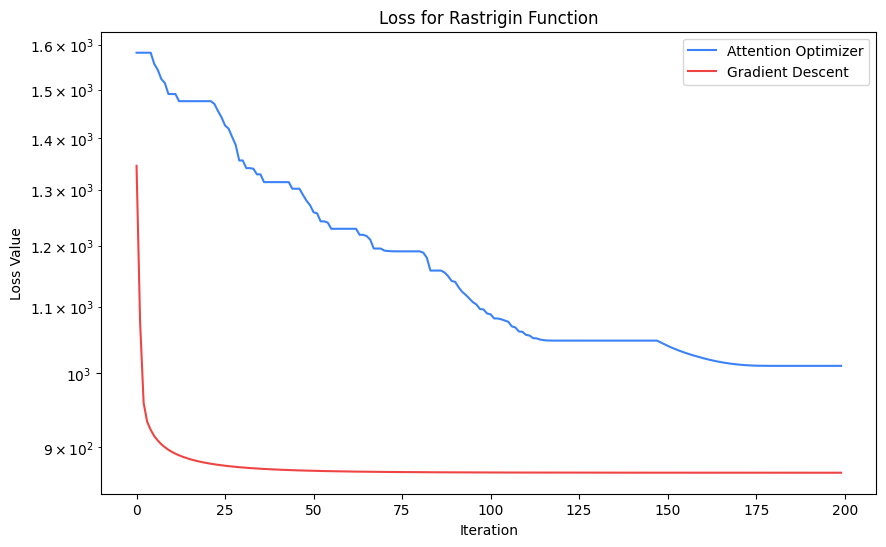


Testing Ackley Function (Dimension=100)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                 5.11  |            10.4    |
| Computation Time (s) |                 0.024 |             0.0156 |


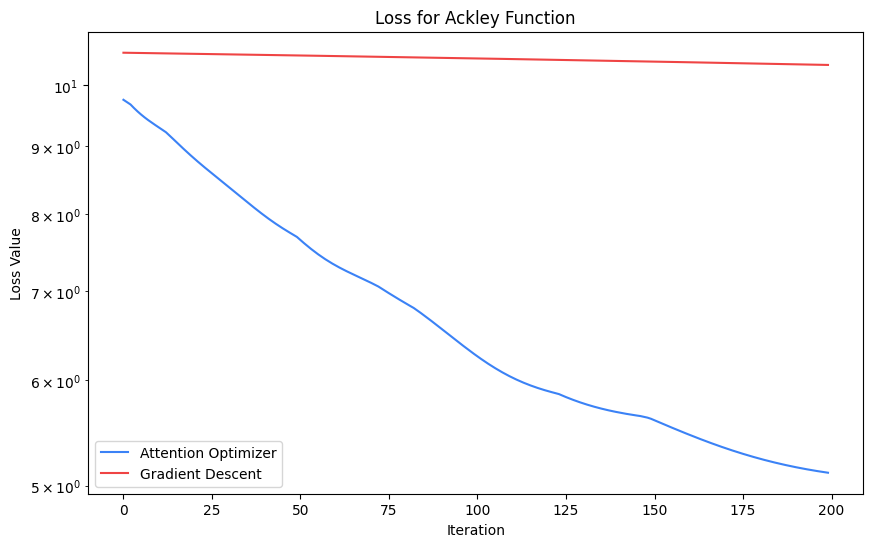


Testing Griewank Function (Dimension=100)
| Metric               |   Attention Optimizer |   Gradient Descent |
|:---------------------|----------------------:|-------------------:|
| Final Loss           |                0.777  |             1.21   |
| Computation Time (s) |                0.0215 |             0.0125 |


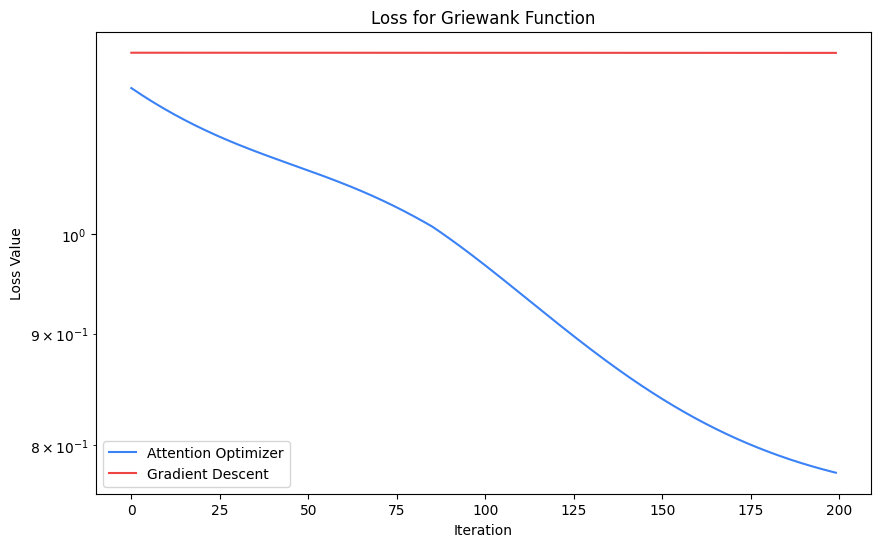

In [ ]:
run_per_dimension(100);